In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import gzip
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [3]:
torch.set_num_threads(7)

# Load data

## Labels

In [4]:
import commons
train_info = commons.read_file('./data/split-0/autotagging_moodtheme-train.tsv')
validation_info = commons.read_file('./data/split-0/autotagging_moodtheme-validation.tsv')
test_info = commons.read_file('./data/split-0/autotagging_moodtheme-test.tsv')

Reading: 9949 tracks, 2471 albums, 874 artists
Reading: 3802 tracks, 927 albums, 307 artists
Reading: 4231 tracks, 1025 albums, 327 artists


In [5]:
def parse(a_info):
    ans = []
    for k,v in a_info[1]['mood/theme'].items():
        ans.append(pd.DataFrame({
            k: 1,
            'file': list(v)
        }))

    df = ans[0]
    for x in ans[1:]:
        df = pd.merge(df, x, on='file', how='outer')
    df = df.set_index('file').fillna(0)
    df.loc[:, :] = df.loc[:, :].astype('int64')
    return df

In [6]:
train_df = parse(train_info)
valid_df = parse(validation_info)
test_df = parse(test_info)

In [7]:
train_df.shape
valid_df.shape
test_df.shape

(9949, 56)

(3802, 56)

(4231, 56)

In [8]:
train_df = train_df.loc[:, sorted(train_df.columns.tolist())]
valid_df = valid_df.loc[:, sorted(train_df.columns.tolist())]
test_df = test_df.loc[:, sorted(train_df.columns.tolist())]

In [9]:
train_df.sample(2)

,action,adventure,advertising,background,ballad,calm,children,christmas,commercial,cool,...,slow,soft,soundscape,space,sport,summer,trailer,travel,upbeat,uplifting
file,,,,,,,,,,,,,,,,,,,,,
1309733,0,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
862195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Define datasets and augmentation

In [10]:
def np_load_gz(x):
    with gzip.open(x, 'rb') as f:
        return np.load(f)

In [11]:
import random

In [12]:
def random_30s(x):
    x_len = x.shape[1]
    offset = random.randint(0, (x_len - 1407))
    return x[:, offset:(offset + 1407)]

In [13]:
from transforms import get_transforms

In [14]:
train_transform = get_transforms(
    train=True,
    size=6590,
    wrap_pad_prob=0.5,
    resize_scale=(0.8, 1.0),
    resize_ratio=(1.7, 2.3),
    resize_prob=0.33,
    spec_num_mask=2,
    spec_freq_masking=0.15,
    spec_time_masking=0.20,
    spec_prob=0.5
)
val_transform = get_transforms(False, 6590)

In [15]:
class AudioDataset(Dataset):
    
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        
        this_file = self.df.index[idx]
        sample = np_load_gz('./data/melspecs/{}.npy.gz'.format(this_file))
        
        image = sample
                
        if self.transform is not None:
            image = self.transform(image)
        
        return image, torch.Tensor(self.df.values[idx])

In [16]:
train_dataset = AudioDataset(train_df, train_transform)
valid_dataset = AudioDataset(valid_df, val_transform)
test_dataset = AudioDataset(test_df, val_transform)

In [17]:
train_dataset[100][0].shape, train_dataset[100][1].shape

(torch.Size([1, 96, 6590]), torch.Size([56]))

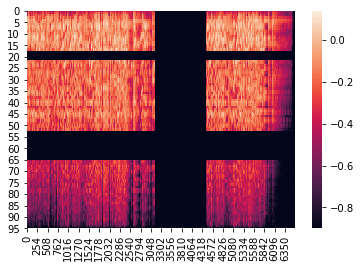

In [18]:
import seaborn as sns
sns.heatmap(train_dataset[100][0][0,:,:].numpy());

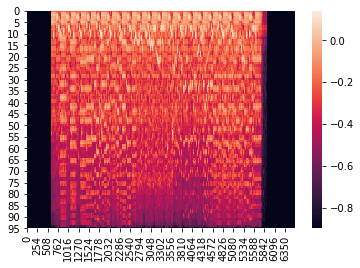

In [19]:
sns.heatmap(valid_dataset[100][0][0,:,:].numpy());

# Model

In [20]:
import torchvision.models

In [21]:
class Model(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.bw2col = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 10, 1, padding=0), nn.ReLU(),
            nn.Conv2d(10, 3, 1, padding=0), nn.ReLU())
        
        self.mv2 = torchvision.models.mobilenet_v2(pretrained=True)
        
        self.mv2.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, 56),
        )
    
    def forward(self, x):
        x = self.bw2col(x)
        x = self.mv2.features(x)
        x = x.mean([2, 3])
        x = self.mv2.classifier(x)
        return x

# Training

In [22]:
cuda=True
device = torch.device('cuda:0' if cuda else 'cpu')
print('Device: ', device)

Device:  cuda:0


In [23]:
model = Model().to(device)

In [24]:
optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [25]:
criterion = nn.BCEWithLogitsLoss(reduction='none')

----

In [26]:
val_loader = DataLoader(valid_dataset, 4, shuffle=False, num_workers=4)
train_loader_1 = DataLoader(train_dataset, 4, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)
train_loader_2 = DataLoader(train_dataset, 4, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)

In [27]:
epochs = 100

In [35]:
train_loss_hist = []
train_loss_hist_each_class = []

valid_loss_hist = []
valid_loss_hist_each_class = []

lowest_val_loss = np.inf
lowest_val_loss_each_class = np.array([float('inf') for _ in range(56)])
epochs_without_new_lowest = 0

for i in range(epochs):
    print('Epoch: ', i)
    
    this_epoch_train_loss = 0
    this_epoch_train_loss_each_class = np.zeros(56)
    for i1, i2 in zip(train_loader_1, train_loader_2):
        
        # mixup---------
        alpha = 1
        mixup_vals = np.random.beta(alpha, alpha, i1[0].shape[0])
        
        lam = torch.Tensor(mixup_vals.reshape(mixup_vals.shape[0], 1, 1, 1))
        inputs = (lam * i1[0]) + ((1 - lam) * i2[0])
        
        lam = torch.Tensor(mixup_vals.reshape(mixup_vals.shape[0], 1))
        labels = (lam * i1[1]) + ((1 - lam) * i2[1])
        # mixup ends ----------
        
        # https://stackoverflow.com/questions/55563376/pytorch-how-does-pin-memory-works-in-dataloader
        inputs = inputs.to(device, non_blocking=False)
        labels = labels.to(device, non_blocking=False)
        
        
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            model = model.train()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            total_loss = loss.mean(dim=0).mean(dim=0)
            total_loss.backward()
            optimizer.step()
            
            loss_val = total_loss.detach().cpu().numpy()
            loss_val_each_class = loss.mean(dim=0).detach().cpu().numpy()
            
            this_epoch_train_loss += loss_val
            this_epoch_train_loss_each_class += loss_val_each_class
    
    this_epoch_valid_loss = 0
    this_epoch_valid_loss_each_class = np.zeros(56)
    for inputs, labels in val_loader:
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            model = model.eval()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            
            loss_val = loss.mean(dim=0).mean(dim=0).detach().cpu().numpy()
            loss_val_each_class = loss.mean(dim=0).detach().cpu().numpy()
            
            this_epoch_valid_loss += loss_val
            this_epoch_valid_loss_each_class += loss_val_each_class
    
    this_epoch_train_loss /= len(train_loader_1)
    this_epoch_train_loss_each_class /= len(train_loader_1)
    
    this_epoch_valid_loss /= len(val_loader)
    this_epoch_valid_loss_each_class /= len(val_loader)
    
    train_loss_hist.append(this_epoch_train_loss)
    train_loss_hist_each_class.append(this_epoch_train_loss_each_class)
    valid_loss_hist.append(this_epoch_valid_loss)
    valid_loss_hist_each_class.append(this_epoch_valid_loss_each_class)
    
    if this_epoch_valid_loss < lowest_val_loss:
        lowest_val_loss = this_epoch_valid_loss
        torch.save(model.state_dict(), './model')
        epochs_without_new_lowest = 0
    else:
        epochs_without_new_lowest += 1
    
    for i in range(56):
        if this_epoch_valid_loss_each_class[i] < lowest_val_loss_each_class[i]:
            lowest_val_loss_each_class[i] = this_epoch_valid_loss_each_class[i]
            torch.save(model.state_dict(), './model_c{}'.format(i))
    
    if epochs_without_new_lowest >= 25:
        break
    
    print(this_epoch_train_loss, this_epoch_valid_loss)
    
    scheduler.step(this_epoch_valid_loss)

Epoch:  0
0.13809405236044558 0.12477137677434112
Epoch:  1
0.13270569244780595 0.12326968188921944
Epoch:  2
0.1319778569990502 0.1227533718054535
Epoch:  3
0.13014655128337335 0.12227479756629768
Epoch:  4
0.12997494310428556 0.12124353656623543
Epoch:  5
0.12876503393893848 0.12196856007731262
Epoch:  6
0.12867870799681222 0.12181607320779513
Epoch:  7
0.1276475450746871 0.12221033667691615
Epoch:  8
0.12810007299202075 0.12129749329525884
Epoch:  9
0.1269794947043325 0.12094972112036052
Epoch:  10
0.12682885790600676 0.12166248302625007
Epoch:  11
0.12679930478814336 0.12015038234095614
Epoch:  12
0.12665920811382853 0.12673487597215577
Epoch:  13
0.1263657315917637 0.1207006549885293
Epoch:  14
0.12618150061743272 0.12086259997880258
Epoch:  15
0.12521416657932716 0.12305946984649205
Epoch:  16
0.12529059407119783 0.11968345540974822
Epoch:  17
0.12489949497911665 0.12043659902420364
Epoch:  18
0.12481557117136205 0.1230679908845605
Epoch:  19
0.12462313522415269 0.121146149604636

# Final evaluation using the overall best model

In [27]:
model.load_state_dict(torch.load('./model'))

<All keys matched successfully>

In [28]:
val_loader = DataLoader(valid_dataset, 16, shuffle=False, num_workers=6)

In [29]:
this_epoch_valid_loss = 0
all_outputs = []
all_inputs = []
for inputs, labels in val_loader:
    
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        model = model.eval()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss_val = loss.mean(dim=0).mean(dim=0).detach().cpu().numpy()
        this_epoch_valid_loss += loss_val
        
        all_outputs.append(outputs.detach().cpu().numpy())
        all_inputs.append(labels.detach().cpu().numpy())
        

this_epoch_valid_loss /= len(val_loader)

In [30]:
this_epoch_valid_loss

0.11968345540974822

In [31]:
all_outputs = np.concatenate(all_outputs, axis=0)
all_inputs  = np.concatenate(all_inputs,  axis=0)

In [32]:
all_outputs.shape
all_inputs.shape

(3802, 56)

(3802, 56)

In [33]:
all_outputs = 1 / (1 + np.exp(-all_outputs))

In [34]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [35]:
roc_auc_score(all_inputs, all_outputs, average='macro')

0.724660852731379

In [36]:
average_precision_score(all_inputs, all_outputs, average='macro')

0.09853062541031389

In [37]:
pd.DataFrame.from_records([
    (i, roc_auc_score(all_inputs[:, i], all_outputs[:, i]).round(2))
    for i in range(56)
])  

,0,1
0,0,0.74
1,1,0.57
2,2,0.82
3,3,0.53
4,4,0.85
5,5,0.69
6,6,0.69
7,7,0.68
8,8,0.74
9,9,0.75


# Final evaluation using the best model for each class

In [ ]:
final_inputs = []
final_outputs = []
for i in range(56):
    model.load_state_dict(torch.load('./model_c{}'.format(i)))
    val_loader = DataLoader(valid_dataset, 16, shuffle=False, num_workers=6)
    this_epoch_valid_loss = 0
    all_outputs = []
    all_inputs = []
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            model = model.eval()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_val = loss.mean(dim=0).mean(dim=0).detach().cpu().numpy()
            this_epoch_valid_loss += loss_val
            all_outputs.append(outputs.detach().cpu().numpy())
            all_inputs.append(labels.detach().cpu().numpy())
    all_outputs = np.concatenate(all_outputs, axis=0)
    all_inputs  = np.concatenate(all_inputs,  axis=0)
    final_inputs.append(all_inputs[:, [i]])
    final_outputs.append(all_outputs[:, [i]])

In [27]:
all_inputs = np.concatenate(final_inputs, axis=-1)
all_outputs = np.concatenate(final_outputs, axis=-1)

In [28]:
all_outputs = 1 / (1 + np.exp(-all_outputs))

In [29]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [30]:
roc_auc_score(all_inputs, all_outputs, average='macro')

0.7525248829652205

In [31]:
average_precision_score(all_inputs, all_outputs, average='macro')

0.11483545460190892

In [32]:
pd.DataFrame.from_records([
    (i, roc_auc_score(all_inputs[:, i], all_outputs[:, i]).round(2))
    for i in range(56)
])

,0,1
0,0,0.74
1,1,0.61
2,2,0.82
3,3,0.65
4,4,0.84
5,5,0.81
6,6,0.74
7,7,0.71
8,8,0.74
9,9,0.82


# Calculate optimal decision thresholds for each class

In [33]:
from sklearn.metrics import precision_recall_curve

In [34]:
# Optimized macro F-score
thresholds = {}
for i in range(56):
    precision, recall, threshold = precision_recall_curve(all_inputs[:, i], all_outputs[:, i])
    f_score = np.nan_to_num((2 * precision * recall) / (precision + recall))
    thresholds[i] = threshold[np.argmax(f_score)]

/home/sai/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


# Create submission

In [ ]:
final_outputs = []
for i in range(56):
    model.load_state_dict(torch.load('./model_c{}'.format(i)))
    test_loader = DataLoader(test_dataset, 32, shuffle=False, num_workers=6)
    all_outputs = []
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            model = model.eval()
            outputs = model(inputs)
            all_outputs.append(outputs.detach().cpu().numpy())
    all_outputs = np.concatenate(all_outputs, axis=0)
    final_outputs.append(all_outputs[:, [i]])

In [38]:
all_outputs = np.concatenate(final_outputs, axis=-1)

In [39]:
all_outputs = 1 / (1 + np.exp(-all_outputs))

In [47]:
pd.read_csv('./moodtheme_split.txt', header=None).iloc[:, 0].str[13:].tolist() == sorted(train_df.columns.tolist())

True

In [51]:
all_outputs.shape, all_outputs.astype('float64').dtype

((4231, 56), dtype('float64'))

In [53]:
np.save('predictions.npy', all_outputs.astype('float64'))

In [55]:
decisions = []
for i in range(56):
    decisions.append(
        all_outputs[:, [i]] > thresholds[i]
    )
decisions = np.concatenate(decisions, axis=-1)

In [56]:
decisions.shape, decisions.dtype

((4231, 56), dtype('bool'))

In [57]:
np.save('decisions.npy', decisions)